In [ ]:
#https://www.kaggle.com/code/pcbreviglieri/predicting-smart-grid-stability-with-deep-learning

The ascent of renewable energy sources provides the global community with a much demanded alternative to traditional, finite and climate-unfriendly fossil fuels. However, their adoption poses a set of new paradigms, out of which two interrelated aspects deserve particular attention:

Prior to the rise of renewable energy sources, the traditional operating ecosystem involved few production entities (sources) supplying energy to consumers over unidirectional flows. With the advent of renewable options, end users (households and enterprises) now not only consume energy but have the ability to produce and supply it - hence a new term to designate them, 'prosumers'. As a result, energy flow within distribution grids - 'smart grids' - has become bidirectional;
Despite the increased flexibility brought in by the introduction of renewable sources and the aforementioned emergence of 'prosumers', the management of supply and demand in a more complex generation / distribution / consumption environment and the related economic implications (particularly the decision to buy energy at a given price or not) have become even more challenging.
Relevant contributions on how to tackle the requirements of such new scenario have been offered by academy and industry over the past years. Special attention has been devoted to the study of smart grid stability.

In a smart grid, consumer demand information is collected, centrally evaluated against current supply conditions and the resulting proposed price information is sent back to customers for them to decide about usage. As the whole process is time-dependent, dinamically estimating grid stability becomes not only a concern but a major requirement.

Put simply, the objective is to understand and plan for both energy production and/or consumption disturbances and fluctuations introduced by system participants in a dynamic way, taking into consideration not only technical aspects but also how participants respond to changes in the associated economic aspects (energy price).

The work of researchers cited in foreword focuses on Decentral Smart Grid Control (DSGC) systems, a methodology strictly tied to monitoring one particular property of the grid - its frequency.

The term 'frequency' refers to the alternate current (AC) frequency, measured in cycles per second or its equivalent unit, Hertz (Hz). Around the world AC frequencies of either 50 or 60 Hz are utilized in electric power generation-distribution systems.

It is known that the electrical signal frequency "increases in times of excess generation, while it decreases in times of underproduction" [1]. Therefore, measuring the grid frequency at the premise of each customer would suffice to provide the network administrator with all required information about the current network power balance, so that it can price its energy offering - and inform consumers - accordingly.

The DSGC differential equation-based mathematical model described in [1] and assessed in [2] aims at identifying grid instability for a reference 4-node star architecture, comprising one power source (a centralized generation node) supplying energy to three consumption nodes. The model takes into consideration inputs (features) related to:

the total power balance (nominal power produced or consumed at each grid node);
the response time of participants to adjust consumption and/or production in response to price changes (referred to as "reaction time);
energy price elasticity.

The dataset chosen for this machine learning exercise has a synthetic nature and contains results from simulations of grid stability for a reference 4-node star network, as described in 1.2.

The original dataset contains 10,000 observations. As the reference grid is symetric, the dataset can be augmented in 3! (3 factorial) times, or 6 times, representing a permutation of the three consumers occupying three consumer nodes. The augmented version has then 60,000 observations. It also contains 12 primary predictive features and two dependent variables.

Predictive features:

'tau1' to 'tau4': the reaction time of each network participant, a real value within the range 0.5 to 10 ('tau1' corresponds to the supplier node, 'tau2' to 'tau4' to the consumer nodes);
'p1' to 'p4': nominal power produced (positive) or consumed (negative) by each network participant, a real value within the range -2.0 to -0.5 for consumers ('p2' to 'p4'). As the total power consumed equals the total power generated, p1 (supplier node) = - (p2 + p3 + p4);
'g1' to 'g4': price elasticity coefficient for each network participant, a real value within the range 0.05 to 1.00 ('g1' corresponds to the supplier node, 'g2' to 'g4' to the consumer nodes; 'g' stands for 'gamma');
Dependent variables:

'stab': the maximum real part of the characteristic differentia equation root (if positive, the system is linearly unstable; if negative, linearly stable);
'stabf': a categorical (binary) label ('stable' or 'unstable').
As there is a direct relationship between 'stab' and 'stabf' ('stabf' = 'stable' if 'stab' <= 0, 'unstable' otherwise), 'stab' will be dropped and 'stabf' will remain as the sole dependent variable.

As the dataset content comes from simulation exercises, there are no missing values. Also, all features are originally numerical, no feature coding is required. Such dataset properties allow for a direct jump to machine modeling without the need of data preprocessing or feature engineering.

In [ ]:
#dataset info^^

## Data and Library load

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Portofolio/smart_grid_stab

/content/drive/MyDrive/Portofolio/smart_grid_stab


In [3]:
!ls

Callbacks		 representative_labels.csv
model_quant.ipynb	 smart_grid_stability_augmented.csv
Models			 smart_grid_stability_train.ipynb
representative_data.csv  TFLite_Models


In [4]:
import numpy as np
import pandas as pd

from pandas import datetime
import missingno as msno
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

from numpy.random import randn
import os
import random
import time

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


In [5]:
df = pd.read_csv("smart_grid_stability_augmented.csv")
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


## Dataset Information



In [ ]:
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [ ]:
df.shape

(60000, 14)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    60000 non-null  float64
 1   tau2    60000 non-null  float64
 2   tau3    60000 non-null  float64
 3   tau4    60000 non-null  float64
 4   p1      60000 non-null  float64
 5   p2      60000 non-null  float64
 6   p3      60000 non-null  float64
 7   p4      60000 non-null  float64
 8   g1      60000 non-null  float64
 9   g2      60000 non-null  float64
 10  g3      60000 non-null  float64
 11  g4      60000 non-null  float64
 12  stab    60000 non-null  float64
 13  stabf   60000 non-null  object 
dtypes: float64(13), object(1)
memory usage: 6.4+ MB


In [ ]:
df.describe()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,5.250000,5.250001,5.250001,5.250001,3.750000,-1.250000,-1.250000,-1.250000,0.525000,0.525000,0.525000,0.525000,0.015731
std,2.742434,2.742437,2.742437,2.742437,0.752129,0.433017,0.433017,0.433017,0.274244,0.274243,0.274243,0.274243,0.036917
min,0.500793,0.500141,0.500141,0.500141,1.582590,-1.999945,-1.999945,-1.999945,0.050009,0.050028,0.050028,0.050028,-0.080760
25%,2.874892,2.875011,2.875011,2.875011,3.218300,-1.624997,-1.624997,-1.624997,0.287521,0.287497,0.287497,0.287497,-0.015557
50%,5.250004,5.249981,5.249981,5.249981,3.751025,-1.249996,-1.249996,-1.249996,0.525009,0.525007,0.525007,0.525007,0.017142
75%,7.624690,7.624896,7.624896,7.624896,4.282420,-0.874993,-0.874993,-0.874993,0.762435,0.762490,0.762490,0.762490,0.044878
max,9.999469,9.999837,9.999837,9.999837,5.864418,-0.500025,-0.500025,-0.500025,0.999937,0.999982,0.999982,0.999982,0.109403


In [ ]:
df.duplicated().sum() #no duplicate values

0

In [ ]:
info_dp=pd.DataFrame(df.dtypes,columns=['Data types'])
info_dp['missing']=df.isnull().sum()
info_dp['unique_vals']=df.nunique()
info_dp['count']=df.count()
info_dp#useful info

,Data types,missing,unique_vals,count
tau1,float64,0,10000,60000
tau2,float64,0,30000,60000
tau3,float64,0,30000,60000
tau4,float64,0,30000,60000
p1,float64,0,10000,60000
p2,float64,0,30000,60000
p3,float64,0,30000,60000
p4,float64,0,30000,60000
g1,float64,0,10000,60000
g2,float64,0,30000,60000


## Dataset exploration

In [ ]:
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [ ]:
def assessment(f_data, f_y_feature, f_x_feature, f_index=-1):
    """
    Develops and displays a histogram and a scatter plot for a dependent / independent variable pair from
    a dataframe and, optionally, highlights a specific observation on the plot in a different color (red).
    
    Also optionally, if an independent feature is not informed, the scatterplot is not displayed.
    
    Keyword arguments:
    
    f_data      Tensor containing the dependent / independent variable pair.
                Pandas dataframe
    f_y_feature Dependent variable designation.
                String
    f_x_feature Independent variable designation.
                String
    f_index     If greater or equal to zero, the observation denoted by f_index will be plotted in red.
                Integer
    """
    for f_row in f_data:
        if f_index >= 0:
            f_color = np.where(f_data[f_row].index == f_index,'r','g')
            f_hue = None
        else:
            f_color = 'b'
            f_hue = "stabf"
    
    f_fig, f_a = plt.subplots(1, 2, figsize=(16,4))
    
    f_chart1 = sns.histplot(data=f_data,x=f_x_feature, ax=f_a[0], kde=False, color='g',bins=50,hue=f_hue)
    f_chart1.set_xlabel(f_x_feature,fontsize=10)
    
    if f_index >= 0:
        f_chart2 = plt.scatter(f_data[f_x_feature], f_data[f_y_feature], c=f_color, edgecolors='w')
        f_chart2 = plt.xlabel(f_x_feature, fontsize=10)
        f_chart2 = plt.ylabel(f_y_feature, fontsize=10)
    else:
        f_chart2 = sns.scatterplot(x=f_x_feature, y=f_y_feature, data=f_data, hue=f_hue, legend=False,alpha=0.3)
        f_chart2.set_xlabel(f_x_feature,fontsize=10)
        f_chart2.set_ylabel(f_y_feature,fontsize=10)

    plt.show()

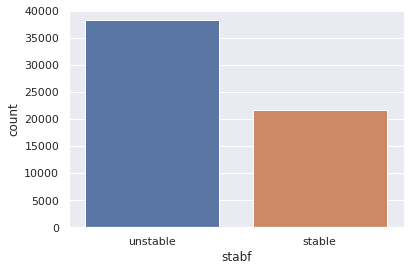

In [ ]:
sns.countplot(data=df,x="stabf");

#### We can observe a class imbalance which we can fix by undersampling the unstable class

In [ ]:
unstab_c,stable_c = df.stabf.value_counts()
mask  = df['stabf'] == "unstable"
unstab = df[mask]
stable = df[~mask]
df_unst = unstab.sample(stable_c)

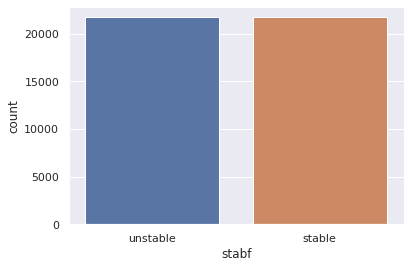

In [ ]:
udf = pd.concat([df_unst,stable],axis=0)
sns.countplot(data=udf,x="stabf");

In [ ]:
sns.set()

#map1 = {'unstable': 0, 'stable': 1} #map labels
#udf['stabf'] = udf['stabf'].replace(map1)

udf = udf.sample(frac=1) #shuffle
data = udf.sample(frac=0.1) #sample for viz purposes

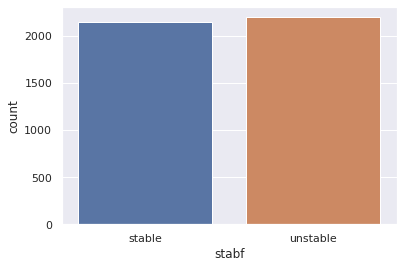

In [ ]:
sns.countplot(data=data,x="stabf");

In [ ]:
for column in data.columns:
    assessment(data, 'stab', column, -1)
    #a histogram and a scatter plot for a dependent / independent variable pair from
    #a dataframe and, optionally, highlights a specific observation on the plot in a different color (red).

Output hidden; open in https://colab.research.google.com to view.

Stable cases tend to have lower tau than unstable cases which tend to have higher

Similarly low g values can be observed more for stable cases than unstable

In [ ]:
def correlation_map(f_data, f_feature, f_number):
    """
    Develops and displays a heatmap plot referenced to a primary feature of a dataframe, highlighting
    the correlation among the 'n' mostly correlated features of the dataframe.
    
    Keyword arguments:
    
    f_data      Tensor containing all relevant features, including the primary.
                Pandas dataframe
    f_feature   The primary feature.
                String
    f_number    The number of features most correlated to the primary feature.
                Integer
    """
    f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index
    f_correlation = f_data[f_most_correlated].corr()
    
    f_mask = np.zeros_like(f_correlation)
    f_mask[np.triu_indices_from(f_mask)] = True
    with sns.axes_style("white"):
        f_fig, f_ax = plt.subplots(figsize=(20, 10))
        sns.heatmap(f_correlation, mask=f_mask, vmin=-1, vmax=1, square=True,
                    center=0, annot=True, annot_kws={"size": 8}, cmap="PRGn")
    plt.show()

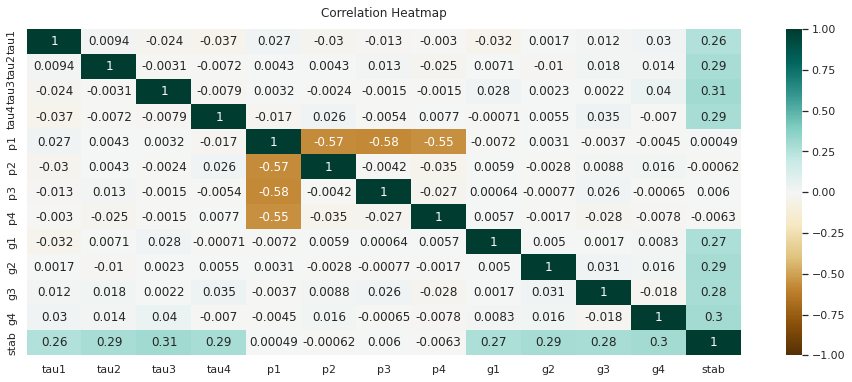

In [ ]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

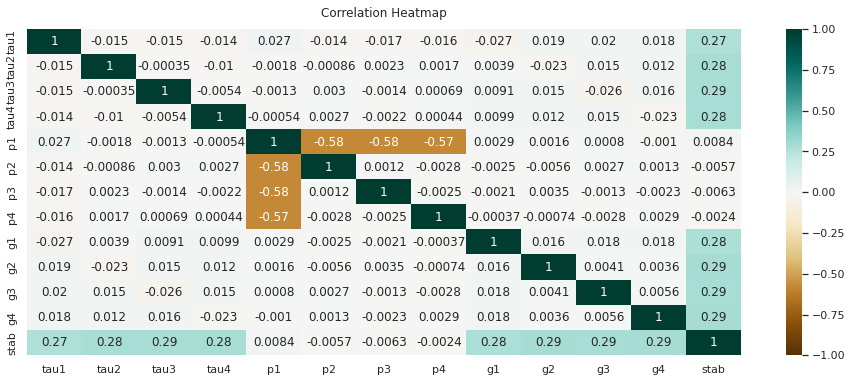

In [ ]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(udf.corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#### We can see a correlation between the p1 and the rest p values

#### At the same time p values have little to zero correlation with the stability variable stab(We could pottentially remove them in the future to simplify them model)

## Data Prep

In [ ]:
udf.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
37174,1.921213,6.172703,1.857065,7.886192,4.218251,-1.374024,-0.927362,-1.916865,0.206966,0.274756,0.702760,0.231773,-0.040072,stable
3600,7.702387,8.125977,5.417316,6.360579,3.680031,-0.816476,-1.178506,-1.685048,0.564903,0.591313,0.116469,0.650433,0.052969,unstable
49160,0.514097,8.522253,0.750002,3.198074,4.365311,-1.611056,-1.019570,-1.734685,0.994149,0.424446,0.649743,0.966970,-0.051424,stable
41331,8.183637,2.405057,3.942842,1.088214,5.307903,-1.795846,-1.762046,-1.750011,0.269930,0.552201,0.352944,0.365977,-0.032817,stable
44834,4.733100,4.852049,8.417705,1.840597,4.132346,-1.699045,-0.719483,-1.713819,0.208593,0.167064,0.651628,0.252928,-0.013545,stable


In [ ]:
map1 = {'unstable': 0, 'stable': 1} #map labels
udf['stabf'] = udf['stabf'].replace(map1)
udf.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
37174,1.921213,6.172703,1.857065,7.886192,4.218251,-1.374024,-0.927362,-1.916865,0.206966,0.274756,0.702760,0.231773,-0.040072,1
3600,7.702387,8.125977,5.417316,6.360579,3.680031,-0.816476,-1.178506,-1.685048,0.564903,0.591313,0.116469,0.650433,0.052969,0
49160,0.514097,8.522253,0.750002,3.198074,4.365311,-1.611056,-1.019570,-1.734685,0.994149,0.424446,0.649743,0.966970,-0.051424,1
41331,8.183637,2.405057,3.942842,1.088214,5.307903,-1.795846,-1.762046,-1.750011,0.269930,0.552201,0.352944,0.365977,-0.032817,1
44834,4.733100,4.852049,8.417705,1.840597,4.132346,-1.699045,-0.719483,-1.713819,0.208593,0.167064,0.651628,0.252928,-0.013545,1


In [ ]:
udf = udf.sample(frac=1) #shuffle

tr = int(udf.shape[0]*0.7)
vt = int(udf.shape[0]*0.15)
train = udf[:tr]
val = udf[tr:tr+vt]
test = udf[tr+vt:]
print(udf.shape,train.shape,val.shape,test.shape)

(43440, 14) (30407, 14) (6516, 14) (6517, 14)


In [ ]:
X_train = train.iloc[:,:-2]
y_train = train.iloc[:,-1]

X_val = val.iloc[:,:-2]
y_val = val.iloc[:,-1]

X_test = test.iloc[:,:-2]
y_test = test.iloc[:,-1]

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
#1X_training = scaler.fit_transform(X_training)
#X_testing = scaler.transform(X_testing)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
scaler.mean_

array([ 5.05753943,  5.06674761,  5.05038863,  5.06747169,  3.74895865,
       -1.249558  , -1.2504632 , -1.24893745,  0.5096795 ,  0.50817165,
        0.50726367,  0.50777028])

In [ ]:
scaler.var_

array([7.83947063, 7.76624963, 7.77626032, 7.77528906, 0.56435616,
       0.1880344 , 0.18738165, 0.18790231, 0.0746486 , 0.07477605,
       0.07507048, 0.07547385])

In [ ]:
repr_df = pd.DataFrame.from_records(X_test)
repr_df.columns = udf.columns[:-2]
repr_df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
0,1.347360,-0.765822,-0.910389,-1.192113,0.320451,0.003686,0.195272,-0.754046,1.563270,0.119907,-0.080848,0.149504
1,0.220956,1.679136,-1.241222,-0.248694,-1.675419,1.657664,0.291911,0.953829,-0.134880,-0.672706,0.551318,-1.424976
2,-0.916888,-1.293003,-1.331651,-1.329583,1.719103,-1.395985,0.083366,-1.666063,1.466270,1.257912,0.264974,-1.039676
3,1.152211,0.655809,-1.170751,-0.123448,0.172703,-0.083205,0.778455,-0.993445,-0.092881,1.344447,-0.603063,-0.983731
4,0.931419,1.580810,-0.348958,-1.485702,0.109953,0.141723,-1.668924,1.334284,-1.035258,-0.594951,1.337576,-0.385165


In [ ]:
repr_df.to_csv('representative_data.csv', index=False)

In [ ]:
repr_df_labels = pd.DataFrame(y_test)
repr_df_labels.head()

,stabf
10816,1
47179,1
36871,1
52732,0
19737,1


In [ ]:
repr_df_labels.to_csv('representative_labels.csv', index=False)

## Model Train

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout

### Model 1

In [ ]:
'''
Adding Callbacks and EarlyStopping
Callbacks and Checkpoints help to keep an eye on model while training and stop the training
if the performance has reached an optimum.
'''
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = 'Callbacks/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')#best accuracy saved

early_stop = EarlyStopping(monitor = 'val_loss', patience = 7, mode="min", verbose = 1,min_delta=0.01,restore_best_weights=True)#go to the model that had the best accuracy before the early stopping before patience epochs
callbacks = [checkpoint, early_stop]

In [ ]:
# ANN initialization
classifier = Sequential()

# Input layer and first hidden layer
classifier.add(Dense(units = 24, activation = 'relu', input_dim = 12))

classifier.add(Dense(units = 24, activation = 'relu'))
classifier.add(Dense(units = 12, activation = 'relu'))

# Single-node output layer
classifier.add(Dense(units = 1, activation = 'sigmoid'))

# ANN compilation
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history = classifier.fit(
    x = X_train,
    y = y_train,
    validation_data=(X_val, y_val),
    epochs = 64,
    batch_size = 64,
    callbacks = callbacks
)

Epoch 1/64
457/476 [===========================>..] - ETA: 0s - loss: 0.4000 - accuracy: 0.8099
Epoch 1: val_accuracy improved from -inf to 0.87416, saving model to Callbacks/weights-improvement-01-0.87.hdf5
476/476 [==============================] - 2s 3ms/step - loss: 0.3954 - accuracy: 0.8124 - val_loss: 0.2784 - val_accuracy: 0.8742
Epoch 2/64
452/476 [===========================>..] - ETA: 0s - loss: 0.2245 - accuracy: 0.9025
Epoch 2: val_accuracy improved from 0.87416 to 0.91529, saving model to Callbacks/weights-improvement-02-0.92.hdf5
476/476 [==============================] - 1s 2ms/step - loss: 0.2225 - accuracy: 0.9032 - val_loss: 0.1895 - val_accuracy: 0.9153
Epoch 3/64
476/476 [==============================] - ETA: 0s - loss: 0.1662 - accuracy: 0.9285
Epoch 3: val_accuracy improved from 0.91529 to 0.93125, saving model to Callbacks/weights-improvement-03-0.93.hdf5
476/476 [==============================] - 1s 2ms/step - loss: 0.1662 - accuracy: 0.9285 - val_loss: 0.1613 

In [ ]:
classifier.save("Models/model1")

INFO:tensorflow:Assets written to: Models/model1/assets


In [ ]:
print("Evaluate on test data")
results = classifier.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)

Evaluate on test data
102/102 [==============================] - 0s 2ms/step - loss: 0.0881 - accuracy: 0.9636
test loss, test acc: [0.08811281621456146, 0.9636335968971252]


In [ ]:
y_pred = classifier.predict(X_test)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

In [ ]:
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(y_test, y_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm

,Predicted Unstable,Predicted Stable
Actual Unstable,3112,148
Actual Stable,89,3168


### Model2

In [ ]:
'''
Adding Callbacks and EarlyStopping
Callbacks and Checkpoints help to keep an eye on model while training and stop the training
if the performance has reached an optimum.
'''
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = 'Callbacks/model2/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')#best accuracy saved

early_stop = EarlyStopping(monitor = 'val_loss', patience = 7, mode="min", verbose = 1,min_delta=0.001,restore_best_weights=True)#go to the model that had the best accuracy before the early stopping before patience epochs
callbacks = [checkpoint, early_stop]

In [ ]:
# ANN initialization
classifier = Sequential()

# Input layer and first hidden layer
classifier.add(Dense(units = 24, activation = 'relu', input_dim = 12))

classifier.add(Dense(units = 24, activation = 'relu'))
classifier.add(Dense(units = 12, activation = 'relu'))

# Single-node output layer
classifier.add(Dense(units = 1, activation = 'sigmoid'))

# ANN compilation
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history = classifier.fit(
    x = X_train,
    y = y_train,
    validation_data=(X_val, y_val),
    epochs = 64,
    batch_size = 64,
    callbacks = callbacks
)

Epoch 1/64
457/476 [===========================>..] - ETA: 0s - loss: 0.3748 - accuracy: 0.8233
Epoch 1: val_accuracy improved from -inf to 0.89518, saving model to Callbacks/model2/weights-improvement-01-0.90.hdf5
476/476 [==============================] - 2s 3ms/step - loss: 0.3700 - accuracy: 0.8258 - val_loss: 0.2335 - val_accuracy: 0.8952
Epoch 2/64
470/476 [============================>.] - ETA: 0s - loss: 0.1901 - accuracy: 0.9184
Epoch 2: val_accuracy improved from 0.89518 to 0.92587, saving model to Callbacks/model2/weights-improvement-02-0.93.hdf5
476/476 [==============================] - 1s 2ms/step - loss: 0.1901 - accuracy: 0.9184 - val_loss: 0.1707 - val_accuracy: 0.9259
Epoch 3/64
469/476 [============================>.] - ETA: 0s - loss: 0.1519 - accuracy: 0.9362
Epoch 3: val_accuracy improved from 0.92587 to 0.93831, saving model to Callbacks/model2/weights-improvement-03-0.94.hdf5
476/476 [==============================] - 1s 2ms/step - loss: 0.1519 - accuracy: 0.936

In [ ]:
classifier.save("Models/model2")

INFO:tensorflow:Assets written to: Models/model2/assets


In [ ]:
print("Evaluate on test data")
results = classifier.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)

Evaluate on test data
102/102 [==============================] - 0s 3ms/step - loss: 0.0803 - accuracy: 0.9681
test loss, test acc: [0.08025768399238586, 0.9680835008621216]


In [ ]:
y_pred = classifier.predict(X_test)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

In [ ]:
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(y_test, y_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm

,Predicted Unstable,Predicted Stable
Actual Unstable,3121,139
Actual Stable,69,3188


### Model3 - Best


In [ ]:
'''
Adding Callbacks and EarlyStopping
Callbacks and Checkpoints help to keep an eye on model while training and stop the training
if the performance has reached an optimum.
'''
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = 'Callbacks/model3/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')#best accuracy saved

early_stop = EarlyStopping(monitor = 'val_loss', patience = 7, mode="min", verbose = 1,min_delta=0.001,restore_best_weights=True)#go to the model that had the best accuracy before the early stopping before patience epochs
callbacks = [checkpoint, early_stop]

In [ ]:
# ANN initialization
classifier = Sequential()

# Input layer and first hidden layer
classifier.add(Dense(units = 256, activation = 'relu', input_dim = 12))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.5))

classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.5))


classifier.add(Dense(units = 64, activation = 'relu'))

# Single-node output layer
classifier.add(Dense(units = 1, activation = 'sigmoid'))

# ANN compilation
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history = classifier.fit(
    x = X_train,
    y = y_train,
    validation_data=(X_val, y_val),
    epochs = 64,
    batch_size = 64,
    callbacks = callbacks
)

Epoch 1/64
471/476 [============================>.] - ETA: 0s - loss: 0.3615 - accuracy: 0.8352
Epoch 1: val_accuracy improved from -inf to 0.92403, saving model to Callbacks/model3/weights-improvement-01-0.92.hdf5
476/476 [==============================] - 4s 6ms/step - loss: 0.3610 - accuracy: 0.8354 - val_loss: 0.1872 - val_accuracy: 0.9240
Epoch 2/64
470/476 [============================>.] - ETA: 0s - loss: 0.2505 - accuracy: 0.8904
Epoch 2: val_accuracy improved from 0.92403 to 0.94782, saving model to Callbacks/model3/weights-improvement-02-0.95.hdf5
476/476 [==============================] - 3s 5ms/step - loss: 0.2500 - accuracy: 0.8905 - val_loss: 0.1391 - val_accuracy: 0.9478
Epoch 3/64
469/476 [============================>.] - ETA: 0s - loss: 0.2166 - accuracy: 0.9059
Epoch 3: val_accuracy did not improve from 0.94782
476/476 [==============================] - 2s 5ms/step - loss: 0.2165 - accuracy: 0.9059 - val_loss: 0.1277 - val_accuracy: 0.9477
Epoch 4/64
472/476 [=======

In [ ]:
classifier.save("Models/model3")

INFO:tensorflow:Assets written to: Models/model3/assets


In [ ]:
print("Evaluate on test data")
results = classifier.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)

Evaluate on test data
102/102 [==============================] - 0s 2ms/step - loss: 0.0738 - accuracy: 0.9715
test loss, test acc: [0.07383926957845688, 0.9714592695236206]


In [ ]:
y_pred = classifier.predict(X_test)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(y_test, y_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm

,Predicted Unstable,Predicted Stable
Actual Unstable,3132,128
Actual Stable,58,3199


In [ ]:
y_pred = classifier.predict(X_test)
y_pred[y_pred <= 0.6] = 0
y_pred[y_pred > 0.6] = 1

from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(y_test, y_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm

,Predicted Unstable,Predicted Stable
Actual Unstable,3176,84
Actual Stable,89,3168


### Model4

In [ ]:
'''
Adding Callbacks and EarlyStopping
Callbacks and Checkpoints help to keep an eye on model while training and stop the training
if the performance has reached an optimum.
'''
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = 'Callbacks/model4/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')#best accuracy saved

early_stop = EarlyStopping(monitor = 'val_loss', patience = 7, mode="min", verbose = 1,min_delta=0.001,restore_best_weights=True)#go to the model that had the best accuracy before the early stopping before patience epochs
callbacks = [checkpoint, early_stop]

In [ ]:
# ANN initialization
classifier = Sequential()

# Input layer and first hidden layer
classifier.add(Dense(units = 128, activation = 'relu', input_dim = 12))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.5))

classifier.add(Dense(units = 64, activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.5))


classifier.add(Dense(units = 32, activation = 'relu'))

# Single-node output layer
classifier.add(Dense(units = 1, activation = 'sigmoid'))

# ANN compilation
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history = classifier.fit(
    x = X_train,
    y = y_train,
    validation_data=(X_val, y_val),
    epochs = 64,
    batch_size = 64,
    callbacks = callbacks
)

Epoch 1/64
463/476 [============================>.] - ETA: 0s - loss: 0.4488 - accuracy: 0.7848
Epoch 1: val_accuracy improved from -inf to 0.88367, saving model to Callbacks/model4/weights-improvement-01-0.88.hdf5
476/476 [==============================] - 3s 4ms/step - loss: 0.4461 - accuracy: 0.7865 - val_loss: 0.2606 - val_accuracy: 0.8837
Epoch 2/64
474/476 [============================>.] - ETA: 0s - loss: 0.3224 - accuracy: 0.8553
Epoch 2: val_accuracy improved from 0.88367 to 0.92004, saving model to Callbacks/model4/weights-improvement-02-0.92.hdf5
476/476 [==============================] - 2s 3ms/step - loss: 0.3224 - accuracy: 0.8553 - val_loss: 0.1983 - val_accuracy: 0.9200
Epoch 3/64
470/476 [============================>.] - ETA: 0s - loss: 0.2750 - accuracy: 0.8789
Epoch 3: val_accuracy improved from 0.92004 to 0.92710, saving model to Callbacks/model4/weights-improvement-03-0.93.hdf5
476/476 [==============================] - 2s 3ms/step - loss: 0.2743 - accuracy: 0.879

In [ ]:
classifier.save("Models/model4")

INFO:tensorflow:Assets written to: Models/model4/assets


In [ ]:
print("Evaluate on test data")
results = classifier.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)

Evaluate on test data
102/102 [==============================] - 0s 2ms/step - loss: 0.0985 - accuracy: 0.9647
test loss, test acc: [0.09846556186676025, 0.9647076725959778]


In [ ]:
y_pred = classifier.predict(X_test)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(y_test, y_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm

,Predicted Unstable,Predicted Stable
Actual Unstable,3099,161
Actual Stable,69,3188


In [ ]:
y_pred = classifier.predict(X_test)
y_pred[y_pred <= 0.6] = 0
y_pred[y_pred > 0.6] = 1

from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(y_test, y_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm

,Predicted Unstable,Predicted Stable
Actual Unstable,3155,105
Actual Stable,134,3123


### Model 5

In [ ]:
'''
Adding Callbacks and EarlyStopping
Callbacks and Checkpoints help to keep an eye on model while training and stop the training
if the performance has reached an optimum.
'''
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = 'Callbacks/model5/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')#best accuracy saved

early_stop = EarlyStopping(monitor = 'val_loss', patience = 7, mode="min", verbose = 1,min_delta=0.001,restore_best_weights=True)#go to the model that had the best accuracy before the early stopping before patience epochs
callbacks = [checkpoint, early_stop]

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_rate=0.9,
    decay_steps=1500,
    staircase=True
)

In [ ]:
# ANN initialization
# Model structure

classifier = tf.keras.models.Sequential()


classifier.add(Dense(
    units=256,
    activation='relu',
    input_dim = 12
))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.5))

classifier.add(Dense(
    units=128,
    activation='relu',
))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.5))

classifier.add(Dense(
    units=64,
    activation='relu',
))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.5))

classifier.add(Dense(
    units=32,
    activation='relu',
))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.5))

classifier.add(Dense(
    units=16,
    activation='relu',
))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.5))

classifier.add(Dense(
    units=8,
    activation='relu',
))


# Single-node output layer
classifier.add(Dense(units = 1, activation = 'sigmoid'))

# ANN compilation
classifier.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
history = classifier.fit(
    x = X_train,
    y = y_train,
    validation_data=(X_val, y_val),
    epochs = 64,
    batch_size = 64,
    callbacks = callbacks
)

Epoch 1/64
474/476 [============================>.] - ETA: 0s - loss: 0.5782 - accuracy: 0.6840
Epoch 1: val_accuracy improved from -inf to 0.87247, saving model to Callbacks/model5/weights-improvement-01-0.87.hdf5
476/476 [==============================] - 5s 7ms/step - loss: 0.5779 - accuracy: 0.6842 - val_loss: 0.2981 - val_accuracy: 0.8725
Epoch 2/64
475/476 [============================>.] - ETA: 0s - loss: 0.3623 - accuracy: 0.8473
Epoch 2: val_accuracy improved from 0.87247 to 0.91835, saving model to Callbacks/model5/weights-improvement-02-0.92.hdf5
476/476 [==============================] - 3s 6ms/step - loss: 0.3625 - accuracy: 0.8472 - val_loss: 0.1952 - val_accuracy: 0.9184
Epoch 3/64
471/476 [============================>.] - ETA: 0s - loss: 0.2935 - accuracy: 0.8760
Epoch 3: val_accuracy improved from 0.91835 to 0.93462, saving model to Callbacks/model5/weights-improvement-03-0.93.hdf5
476/476 [==============================] - 3s 7ms/step - loss: 0.2934 - accuracy: 0.875

In [ ]:
classifier.save("Models/model5")

INFO:tensorflow:Assets written to: Models/model5/assets


In [ ]:
print("Evaluate on test data")
results = classifier.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)

Evaluate on test data
102/102 [==============================] - 0s 2ms/step - loss: 0.0838 - accuracy: 0.9650
test loss, test acc: [0.08376693725585938, 0.9650145769119263]


In [ ]:
y_pred = classifier.predict(X_test)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(y_test, y_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm

,Predicted Unstable,Predicted Stable
Actual Unstable,3071,189
Actual Stable,39,3218


In [ ]:
y_pred = classifier.predict(X_test)
y_pred[y_pred <= 0.6] = 0
y_pred[y_pred > 0.6] = 1

from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(y_test, y_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm

,Predicted Unstable,Predicted Stable
Actual Unstable,3210,50
Actual Stable,180,3077


### Model 6

In [ ]:
'''
Adding Callbacks and EarlyStopping
Callbacks and Checkpoints help to keep an eye on model while training and stop the training
if the performance has reached an optimum.
'''
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = 'Callbacks/model6/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')#best accuracy saved

early_stop = EarlyStopping(monitor = 'val_loss', patience = 7, mode="min", verbose = 1,min_delta=0.001,restore_best_weights=True)#go to the model that had the best accuracy before the early stopping before patience epochs
callbacks = [checkpoint, early_stop]

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_rate=0.9,
    decay_steps=1500,
    staircase=True
)

In [ ]:
# ANN initialization
# Model structure

classifier = tf.keras.models.Sequential()

classifier.add(Dense(
    units=128,
    activation='relu',
     input_dim = 12
))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.5))


classifier.add(Dense(
    units=32,
    activation='relu',
))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.5))


classifier.add(Dense(
    units=8,
    activation='relu',
))


# Single-node output layer
classifier.add(Dense(units = 1, activation = 'sigmoid'))

# ANN compilation
classifier.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
history = classifier.fit(
    x = X_train,
    y = y_train,
    validation_data=(X_val, y_val),
    epochs = 64,
    batch_size = 64,
    callbacks = callbacks
)

Epoch 1/64
474/476 [============================>.] - ETA: 0s - loss: 0.7137 - accuracy: 0.5969
Epoch 1: val_accuracy improved from -inf to 0.77855, saving model to Callbacks/model6/weights-improvement-01-0.78.hdf5
476/476 [==============================] - 3s 4ms/step - loss: 0.7134 - accuracy: 0.5971 - val_loss: 0.5244 - val_accuracy: 0.7785
Epoch 2/64
475/476 [============================>.] - ETA: 0s - loss: 0.5670 - accuracy: 0.7124
Epoch 2: val_accuracy improved from 0.77855 to 0.81077, saving model to Callbacks/model6/weights-improvement-02-0.81.hdf5
476/476 [==============================] - 2s 3ms/step - loss: 0.5669 - accuracy: 0.7124 - val_loss: 0.4451 - val_accuracy: 0.8108
Epoch 3/64
472/476 [============================>.] - ETA: 0s - loss: 0.5048 - accuracy: 0.7532
Epoch 3: val_accuracy improved from 0.81077 to 0.82443, saving model to Callbacks/model6/weights-improvement-03-0.82.hdf5
476/476 [==============================] - 2s 3ms/step - loss: 0.5047 - accuracy: 0.753

In [ ]:
classifier.save("Models/model6")

INFO:tensorflow:Assets written to: Models/model6/assets


In [ ]:
print("Evaluate on test data")
results = classifier.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)

Evaluate on test data
102/102 [==============================] - 0s 1ms/step - loss: 0.1661 - accuracy: 0.9382
test loss, test acc: [0.16613666713237762, 0.9381617307662964]


In [ ]:
y_pred = classifier.predict(X_test)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(y_test, y_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm

,Predicted Unstable,Predicted Stable
Actual Unstable,2988,272
Actual Stable,131,3126


In [ ]:
y_pred = classifier.predict(X_test)
y_pred[y_pred <= 0.6] = 0
y_pred[y_pred > 0.6] = 1

from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(y_test, y_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm

,Predicted Unstable,Predicted Stable
Actual Unstable,3088,172
Actual Stable,230,3027
